In [ ]:
!pip install pandas
!pip install numpy==1.23

In [ ]:
!pip install tensorflow==2.12
!pip install pyarabic

In [ ]:
!pip install transformers

In [ ]:
!pip install ipywidgets
!pip install datasets
!pip install transformers[torch]
!pip install nvidia-ml-py3

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [1]:
# cell-1  
#load and clean the data (removing diacritics and unwanted text)



import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 


import numpy as np
import pandas as pd
import pyarabic.araby as araby
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)


df = pd.read_csv('poemsDataset.csv')
df.fillna('', inplace=True)
display(len(df))


def remove_diacritics(a):    
    return araby.strip_diacritics(a)

df['first_hemistich'] = df['first_hemistich'].apply(remove_diacritics)
df['second_hemistich'] = df['second_hemistich'].apply(remove_diacritics)

def normalizeBeforeTraining(df):
    df['first_hemistich'] = df['first_hemistich'].str.replace('النابغـة: ', '')
    df['second_hemistich'] = df['second_hemistich'].str.replace('الـربيع: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('عبيــد: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('امـرؤ القيسـ: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('امرؤ القيس: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(جلال الــــدين الــــرومي):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(لـوك الفيلسـوف الإنكليزي):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(كانت الفيلسوف الألماني ):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(بركســــــــــــــــون):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الحـــــــــــــــور):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الشــــــــــــــاعر):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الإنســـــــــــــــان):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('العلم):', '', regex=False)
    df['first_hemistich'] = df['first_hemistich'].str.replace('(العشــــــــــــــــق):', '', regex=False)
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الزهــــــــــــــــــرة):', '', regex=False)
    df['second_hemistich'] = df['second_hemistich'].str.replace('التوأم اليشكري: ', '', regex=False)  
    df['first_hemistich'] = df['first_hemistich'].str.replace('آ', 'أ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('آ', 'أ')
    df['first_hemistich'] = df['first_hemistich'].str.replace('[/":?،؟]', '')
    df['second_hemistich'] = df['second_hemistich'].str.replace('[/":?،؟]', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('  ', ' ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('  ', ' ')
    df['first_hemistich'] = df['first_hemistich'].str.replace('  ', ' ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('  ', ' ')


normalizeBeforeTraining(df)
df.drop(df[(df['first_hemistich'] == '') & (df['second_hemistich'] == '')].index, inplace=True)

#if first_hemistich == '', then copy the text from second_hemistich. then delete the text in the second_hemistich
df['first_hemistich'] = df.apply(lambda x: x['second_hemistich'] if x['first_hemistich'] == '' else x['first_hemistich'], axis=1)
df['second_hemistich'] = df.apply(lambda x: '' if x['first_hemistich'] == x['second_hemistich'] else x['second_hemistich'], axis=1)

df.reset_index(drop=True, inplace=True)

display(len(df))
# display(df[:10])
print('done')

2023-07-29 10:17:33.334674: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-29 10:17:33.358520: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 10:17:33.696626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2090907

2090907

done


In [2]:
# cell-2 
# preparing data for finetuning


df['second_hemistich'].replace('', 'E', inplace=True)
dfc = df[['first_hemistich', 'second_hemistich', 'type_en', 'link']].copy()
dfc['text'] = dfc['first_hemistich'] + ' S ' + dfc['second_hemistich']



dfc['sent'] = ''

dfc.loc[dfc['type_en'] == 'romantic poems', 'sent'] = "love"  
dfc.loc[dfc['type_en'] == 'parting poems', 'sent'] = "love"
dfc.loc[dfc['type_en'] == 'longing poems', 'sent'] = "love"
dfc.loc[dfc['type_en'] == 'spinning poems', 'sent'] = "love"
dfc.loc[dfc['type_en'] == 'elegy poems', 'sent'] = "sad"   
dfc.loc[dfc['type_en'] == 'slander poems', 'sent'] = "angry"
dfc.loc[dfc['type_en'] == 'religious poems', 'sent'] = "religious"
dfc.loc[dfc['type_en'] == 'invocation poems', 'sent'] = "religious"
dfc.loc[dfc['type_en'] == 'mercy poems', 'sent'] = "religious"



dfc = dfc[dfc['sent'] != ''] 



dfc.reset_index(drop=True, inplace=True)

dfc['sent'] = dfc['sent'].astype('category')


dfc['label'] = dfc['sent'].cat.codes #assign cat_value for each sentiment type
dftrain, dftest = train_test_split(dfc, test_size=0.20, random_state=42, stratify=dfc['label'])

ytrain = dftrain['label'].values.tolist()
ytest = dftest['label'].values.tolist()

z = set(dfc['link'].values.tolist())
print(len(z)) #number of poems

max_sequence_length = 32
train_batch_size = 256
classes_num = len(dfc['sent'].unique())

display(classes_num)
display(len(dfc))
display(len(dftrain))
display(len(dftest))

21230


4

315877

252701

63176

In [15]:
x = dfc.groupby(['sent'])['link'].nunique()
x

sent
angry          631
love         15228
religious     2275
sad           3172
Name: link, dtype: int64

In [3]:
#cell-3
#loading the tokenizer and the model

from transformers import AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('faisalq/bert-base-arapoembert')
model = BertForSequenceClassification.from_pretrained('faisalq/bert-base-arapoembert',
                                                      num_labels=classes_num).to('cuda')                                                 
                                                     



Some weights of the model checkpoint at faisalq/bert-base-arapoembert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at faisalq/bert-ba

In [4]:
#cell-4
#tokenizing the data

xtrain = tokenizer(
    text=dftrain['text'].tolist(),
    add_special_tokens=True,
    max_length = max_sequence_length,
    truncation=True,
    padding='max_length', 
    return_tensors='pt',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


xtest = tokenizer(
    text=dftest['text'].tolist(),
    add_special_tokens=True,
    max_length = max_sequence_length,
    truncation=True,
    padding='max_length', 
    return_tensors='pt',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
# display(xtest)
display(xtest['input_ids'][0])
len(xtest['input_ids'][0])

In [5]:
#group text and labels and create train_ds and test_ds

import torch

class NewGroupDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['label'] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

train_ds = NewGroupDataset(xtrain, ytrain)
test_ds = NewGroupDataset(xtest, ytest)

from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return { 'accuracy': acc }

In [6]:
from transformers import Trainer, TrainingArguments


epochs = 2
save_steps = 10000 #save checkpoint every 10000 steps
batch_size = 256

training_args = TrainingArguments(
    output_dir = 'araPoemBERT_base_poemsType/',
    overwrite_output_dir=True,
    num_train_epochs = epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    save_steps = save_steps,
    save_total_limit = 5, #only save the last 5 checkpoints
    fp16=True,
    learning_rate = 5e-5,  # 5e-5 is the default
    logging_steps = 500, #50_000
    evaluation_strategy = 'epoch',
    # evaluate_during_training = True,
    eval_steps = 300
    
)

trainer = Trainer(
    model = model,
    args = training_args,
    # data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics = compute_metrics
)






# trainer.train(resume_from_checkpoint=True)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.651800,0.597735,0.789619
2,0.513000,0.608874,0.789572


TrainOutput(global_step=1976, training_loss=0.5710978411469865, metrics={'train_runtime': 117.5524, 'train_samples_per_second': 4299.377, 'train_steps_per_second': 16.81, 'total_flos': 6935628314390016.0, 'train_loss': 0.5710978411469865, 'epoch': 2.0})

In [7]:
trainer.save_model('araPoemBERT_base_poemsType/')

In [8]:
p = trainer.predict(test_ds)

In [9]:
y_pred = np.argmax(p[0], axis = 1)

print(classification_report(ytest, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.2952    0.0610    0.1011      1016
           1     0.8215    0.9348    0.8745     45274
           2     0.7018    0.6380    0.6684      8686
           3     0.5512    0.2384    0.3329      8200

    accuracy                         0.7896     63176
   macro avg     0.5924    0.4681    0.4942     63176
weighted avg     0.7615    0.7896    0.7634     63176



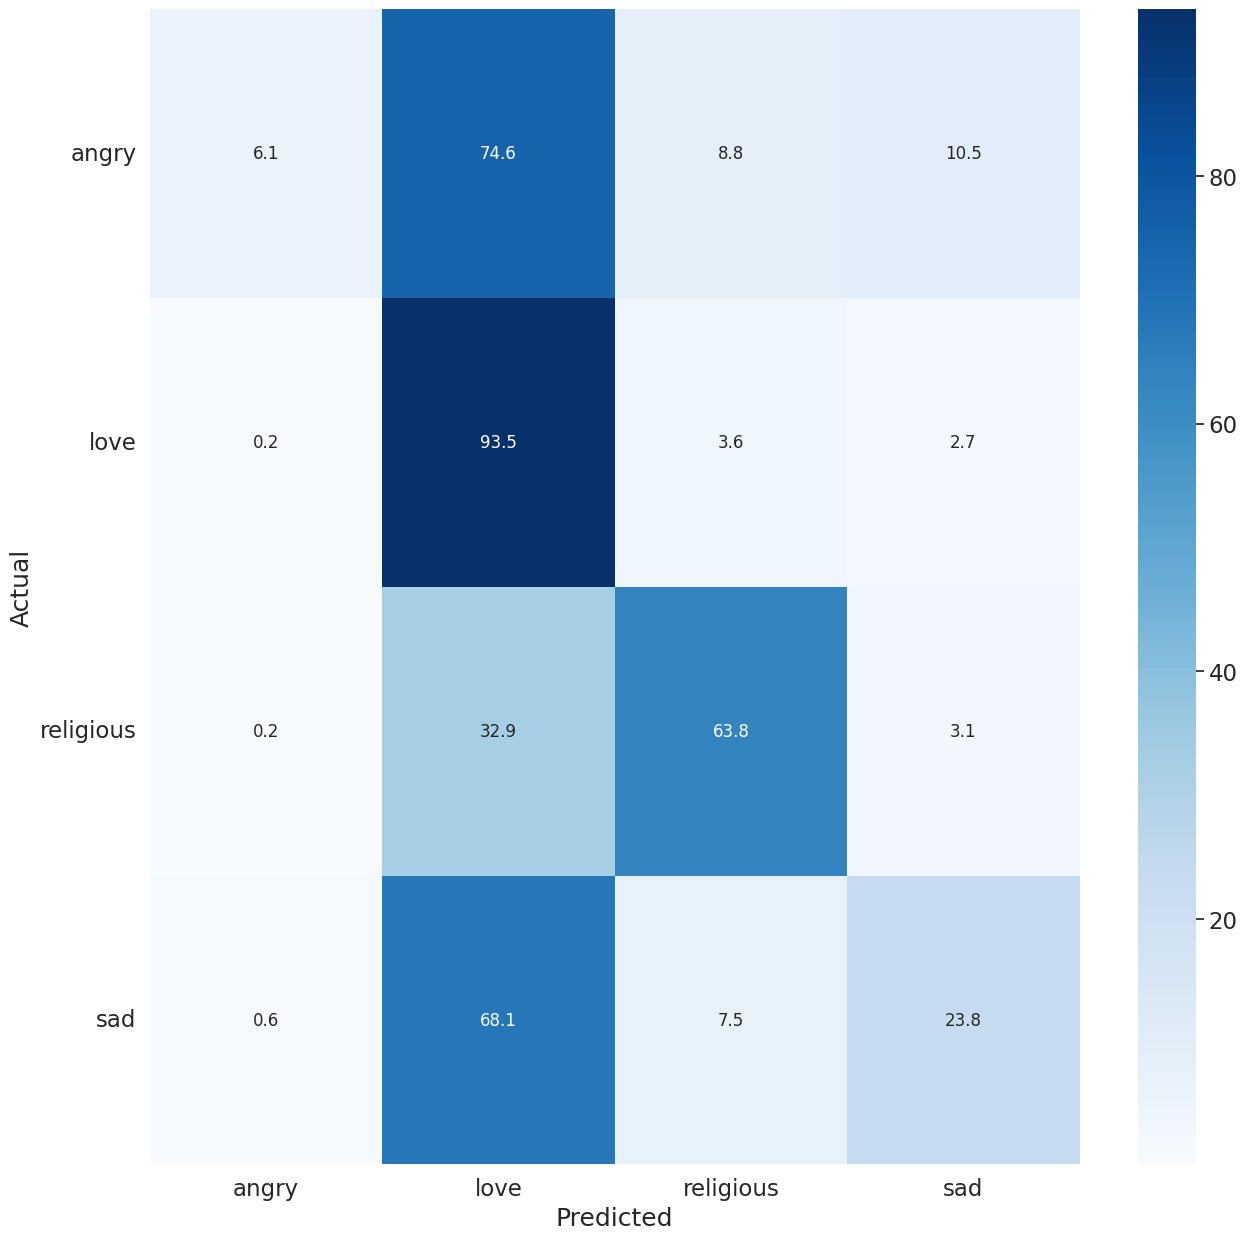

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn, numpy as np
import matplotlib.pyplot as plt

types = [
    'angry',
    'love',
    'religious',
    'sad',
]


matrix = confusion_matrix(ytest, y_pred)
cmn = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
cmn = cmn*100
fig, ax = plt.subplots(figsize=(15,15))
sn.set(font_scale=1.5)
sn.heatmap(cmn, annot=True, fmt='.1f', xticklabels=types, yticklabels=types, cmap="Blues",
          annot_kws={"size": 12})
plt.yticks(rotation=0)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('poem_types_cm.png')
plt.show(block=False)


In [11]:
dfc['m'] = dfc['sent'].astype(str) + ' ' + dfc['label'].astype(str)
df2 = dfc.groupby(['m'])['first_hemistich'].count().sort_values()
display(df2)

m
angry 0          5079
sad 3           41001
religious 2     43429
love 1         226368
Name: first_hemistich, dtype: int64